* after this pick a model and run an ROC and confusion matrix on it and interpret it
* feature importnace, lecture 23

In [34]:
import pandas as pd
import numpy as np
from os.path import dirname, abspath
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib
import statistics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.compose import ColumnTransformer
import matplotlib
from matplotlib import pylab as plt
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [35]:
d = dirname(dirname(abspath("preprocessing.ipynb")))
df_wokring = pd.read_csv(d + '/data/Semi_processed_data.csv') #nrows = 1000)

df = df_wokring.sample(frac=0.03, replace=False, random_state=22) #3% smaple from df for 22794 observations

feature_names = ['start station name', 'end station name', 'gender',
                 'tripduration', 'Start Time','End Time']

label = 'usertype'
user_type = df['usertype']
df.head()
df.shape

(22794, 12)

In [36]:
nans = lambda df: df[df.isnull().any(axis=1)]


In [37]:
df.drop([label, 'birth year','start station latitude','end station latitude',
        'start station longitude', 'end station longitude'], axis = 1, inplace = True)


In [38]:
df.head()

,tripduration,start station name,end station name,gender,Start Time,End Time
35922,224,Jersey & 6th St,Grove St PATH,1,32214.436,32438.436
493350,217,Grove St PATH,Marin Light Rail,1,73627.443,73845.094
558429,680,Riverview Park,Hilltop,1,76253.519,76934.417
285744,228,McGinley Square,Sip Ave,2,24314.744,24543.641
455471,387,Newport Pkwy,Harborside,2,58258.963,58646.882


In [39]:
X = df.loc[:,df.columns != label].values
y = user_type.values

In [40]:
df_y = user_type

In [41]:
#Balance
balance = user_type.value_counts(normalize = True)
balance

Subscriber    0.923357
Customer      0.076643
Name: usertype, dtype: float64

In [42]:
base = balance[0]
print("balance of the data / baseline accuracy = ",base)


balance of the data / baseline accuracy =  0.9233570237781873


In [43]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
def ML_pipeline_kfold_GridSearchCV_RF(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state,stratify=y)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    
    feature_names = ['start station name', 'end station name', 'gender',
                     'tripduration', 'Start Time','End Time']

    cat_ftrs = ['start station name', 'end station name', 'gender']
    num_ftrs = ['tripduration', 'Start Time','End Time']
    
    cat_ftrs_i = [df.columns.get_loc(x) for x in cat_ftrs]
    num_ftrs_i = [df.columns.get_loc(x) for x in num_ftrs]

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False, handle_unknown = 'ignore'))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])


    # collect the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs_i),
            ('cat', categorical_transformer, cat_ftrs_i)]) 

    pipe = make_pipeline(preprocessor, RandomForestClassifier(random_state = 22))
    #pipe = make_pipeline(preprocess, LogisticRegression(penalty='l1', solver='saga', max_iter=10000))
    
    # the parameter(s) we want to tune
    param_grid = {'randomforestclassifier__min_samples_split': range(2,25,5),
                  'randomforestclassifier__max_depth': range(1,30,5)}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                            cv=kf, return_train_score = True,iid=True)
    # do kfold CV on _other
    print("running")
    grid.fit(X_other, y_other)
    return grid, X_test, y_test


* Used the random seed that was close to my test accuracy score

In [70]:
grid, X_test, y_test = ML_pipeline_kfold_GridSearchCV_RF(X,y,22,4)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

# save the output so I can use it later
import pickle
file = open(d + '/results/RF_grid.save', 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()


running
0.9530024677817384
0.9524018425093222
{'randomforestclassifier__max_depth': 26, 'randomforestclassifier__min_samples_split': 22}


In [71]:
file = open(d + '/results/RF_grid.save', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

nr_runs = 10
scores = np.zeros([len(feature_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == "Subscriber")/len(y_test))
# loop through the features
for i in range(len(feature_names)):
    print('shuffling '+str(feature_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_df = pd.DataFrame(X_test, columns = feature_names)
        X_test_shuffled = X_test_df.copy()
        X_test_shuffled[feature_names[i]] = np.random.permutation(X_test_df[feature_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores
    

test score =  0.9524018425093222
test baseline =  0.9234481245887256
shuffling start station name
   shuffled test score: 0.935 +/- 0.002
shuffling end station name
   shuffled test score: 0.952 +/- 0.0
shuffling gender
   shuffled test score: 0.95 +/- 0.001
shuffling tripduration
   shuffled test score: 0.907 +/- 0.002
shuffling Start Time
   shuffled test score: 0.949 +/- 0.001
shuffling End Time
   shuffled test score: 0.95 +/- 0.001


In [117]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
sorted_indcs

array([1, 5, 2, 4, 0, 3])

In [125]:
sorted_feature_names = []
sorted_feature_names.append(feature_names[1])
sorted_feature_names.append(feature_names[5])
sorted_feature_names.append(feature_names[2])
sorted_feature_names.append(feature_names[4])
sorted_feature_names.append(feature_names[0])
sorted_feature_names.append(feature_names[3])


In [126]:
feature_names

['start station name',
 'end station name',
 'gender',
 'tripduration',
 'Start Time',
 'End Time']

In [127]:
sorted_feature_names

['end station name',
 'End Time',
 'gender',
 'Start Time',
 'start station name',
 'tripduration']

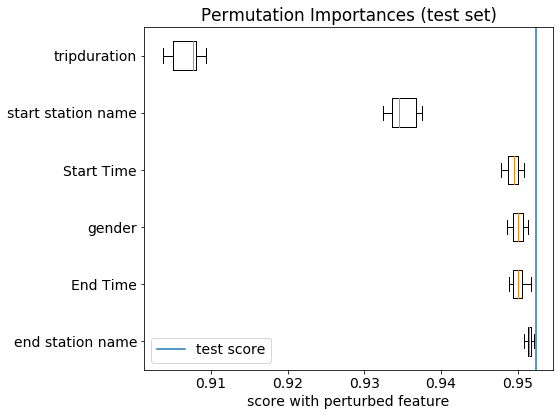

In [131]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=sorted_feature_names,vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.tight_layout()
plt.legend()
plt.savefig(d+'/figures/feature_importance',dpi = 300)
plt.show()

* **RandomForestClassification.feature_importances_**

In [88]:
rndfor = grid.best_estimator_['randomforestclassifier']

In [89]:
rndfor.feature_importances_

array([2.38455053e-01, 5.56078554e-02, 4.39908762e-02, 3.18636771e-04,
       1.29284355e-03, 1.84703479e-03, 2.64975592e-04, 5.19612040e-04,
       2.77395118e-03, 2.07859896e-03, 1.41326341e-03, 1.66039272e-03,
       0.00000000e+00, 2.06319764e-03, 3.84047096e-03, 2.69805050e-03,
       0.00000000e+00, 1.13221680e-03, 1.47966857e-03, 1.52651287e-03,
       3.48337658e-03, 1.62740050e-03, 7.53469841e-09, 2.10941026e-03,
       1.48104112e-03, 5.45931754e-03, 2.14759813e-03, 1.55362808e-03,
       1.35440304e-03, 1.26141999e-03, 1.04467663e-03, 6.00611296e-03,
       0.00000000e+00, 5.15202741e-04, 1.70240700e-03, 9.96197390e-04,
       7.56645396e-04, 1.50674160e-03, 1.98089268e-03, 1.11954695e-02,
       5.22369738e-04, 0.00000000e+00, 1.03856508e-03, 4.21416974e-03,
       1.44496137e-03, 7.54506956e-04, 5.49186441e-04, 3.18482134e-03,
       0.00000000e+00, 1.81657782e-03, 3.01332446e-03, 3.95307904e-03,
       5.23779282e-04, 2.49125884e-03, 2.13561765e-03, 7.71812334e-04,
      

In [83]:
grid

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=22, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          StandardScaler(copy=True,
                                                                      

* Saving 10 RF models